In [20]:
import os
import sys
import cv2
import importlib

ROOT_DIR = os.path.abspath(".")

sys.path.append(ROOT_DIR)

In [21]:
import numpy as np
import math
import mrcnn.model as modellib

import PieColor_randomcolor


import PieColor_randomcolor.ICRNConfigure
from mrcnn.config import Config

from PieColor_randomcolor.Dataset_generator import GenerateOnePieChart

In [22]:
PieColor_randomcolor.ICRNConfigure.MakeDir('testDataset')
PieColor_randomcolor.ICRNConfigure.ClearDir('testDataset')

Resetting the folder..... testDataset


In [23]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA_PieChart"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
maskrcnnconfig = ShapesConfig()
maskrcnnconfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [108]:
#RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/PieChart_color/logs_piechart_Notransferlearning_100000")
RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/PieChart_color/logs_piechart_TransferLearning_COCO")
#RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/PieChart_color/logs_piechart_TransferLearning_imagenet")


In [109]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
maskrcnn_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=RCNNMODEL_DIR)

maskrcnn_model_path = maskrcnn_model.find_last()
#maskrcnn_model_path = 'MaskRCNNlogs/PieChart_color/mask_rcnn_piechart.h5'
# Load trained weights
print("Loading weights from ", maskrcnn_model_path)
maskrcnn_model.load_weights(maskrcnn_model_path, by_name=True)

Loading weights from  /home/mahsa.geshvadi001/projects/PaperCodes/2_Comparison/Instance-based-RN/Codes_PureExperiment_default_5_times/Task1_ourNewTasks/MaskRCNNlogs/PieChart_color/logs_piechart_TransferLearning_COCO/cqa_piechart20230328T1839/mask_rcnn_cqa_piechart_0060.h5
Re-starting from epoch 60


In [110]:
def get_segmented_image(x1, y1, x2, y2, image):
    
    segment = image[x1: y1, x2 : y2]
    new_image = np.ones(shape=(image.shape[0], image.shape[1], image.shape[2]))
    new_image[x1: y1, x2 : y2] = segment
    return new_image

In [111]:
image_num = 1
min_num_obj = 3
max_num_obj = 6

In [112]:
def get_segmented_image_crop(x1, y1, x2, y2, image):
    
    segment = image[x1: y1, x2 : y2]
    new_image = np.ones(shape=(image.shape[0], image.shape[1], image.shape[2]))
    new_image[x1: y1, x2 : y2] = segment
    return new_image

In [113]:
def get_segmented_image(segments_bbs, image):
    
    removed_image = image.copy()
    for i in range(len(segments_bbs)):
        toremovesegment = segments_bbs[i]
    
        x1 = toremovesegment[0]
        y1  = toremovesegment[2]
        x2 = toremovesegment[1]
        y2 = toremovesegment[3]

        removed_image[x1 : y1, x2 : y2] = (1, 1, 1)
        removed_image[x1 : y1, x2 : y2] =removed_image[x1 : y1, x2 : y2] +  np.random.uniform(0, 0.05, (abs(y1-x1), abs(y2-x2),3))
        _min = 0.0  # because the image is not 0/1 black-and-white image, is a RGB image.
        _max = removed_image.max()
        removed_image -= _min
        removed_image[x1 : y1, x2 : y2] /= (_max - _min)
   
    return removed_image

In [132]:
image, _, featureVector = GenerateOnePieChart(
                num=np.random.randint(min_num_obj, max_num_obj + 1))
        
cv2.imwrite('testDataset/' + 'image.png', image * 255)

results = maskrcnn_model.detect([image], verbose=1)

r = results[0]
        

Processing 1 images
image                    shape: (100, 100, 3)         min:    0.04924  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.65020  max: -102.90090  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


In [133]:
r = results[0]

arr = r['rois']
segments_bbs = arr[arr[:,1].argsort()]
segments = []
for t in range(len(r['rois'])):
    segments.append(get_segmented_image([x for x in segments_bbs if ((x != segments_bbs[t]).any())], image))

In [134]:
import matplotlib.pyplot as plt

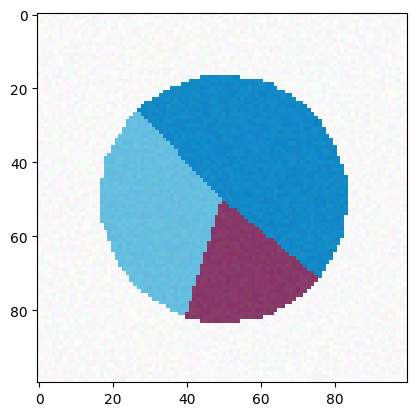

In [135]:
plt.imshow(image)

In [136]:
from mrcnn import visualize

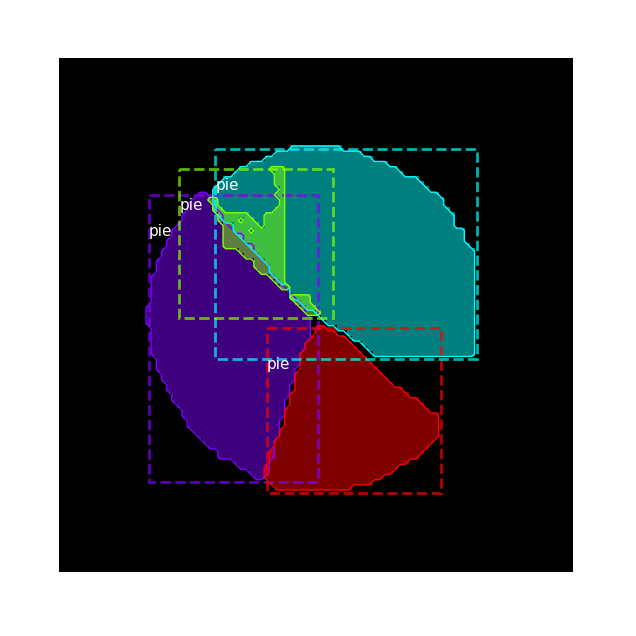

In [137]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'pie'], r['scores'], ax=get_ax())

In [138]:
r['masks'].shape

(100, 100, 4)

In [139]:
x = r['masks'][:,:,1].astype(float)

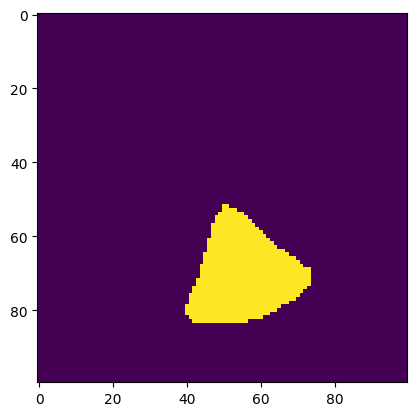

In [140]:
plt.imshow(x)

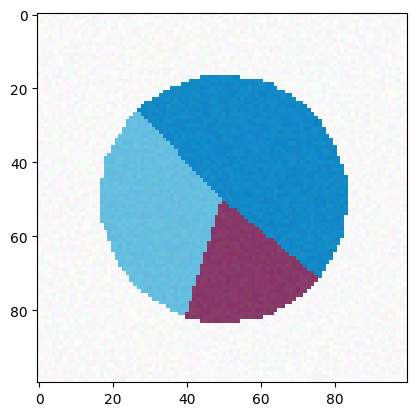

In [141]:
plt.imshow(image)